# Film Junky Union Movie Reviews Machine Learning Models

## Project Statement

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

## Initialization

In [1]:
import math
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score, mean_squared_error, classification_report
import numpy as np
import pandas as pd
import nltk
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from nltk.corpus import stopwords
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import matplotlib.dates as mdates
import seaborn as sns
import sklearn.metrics as metrics
from tqdm.auto import tqdm
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import seaborn as sns

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Load Data

In [4]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

## EDA

Let's Chech For duplicated Values:

In [5]:
duplicated_sum = df_reviews.duplicated().sum()

In [6]:
print(f"""
There are {duplicated_sum} duplicated values in this dataframe.
""")


There are 0 duplicated values in this dataframe.



Let's Check and fill missing values

In [7]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [8]:
df_reviews.isna().sum()

tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     2
votes              2
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64

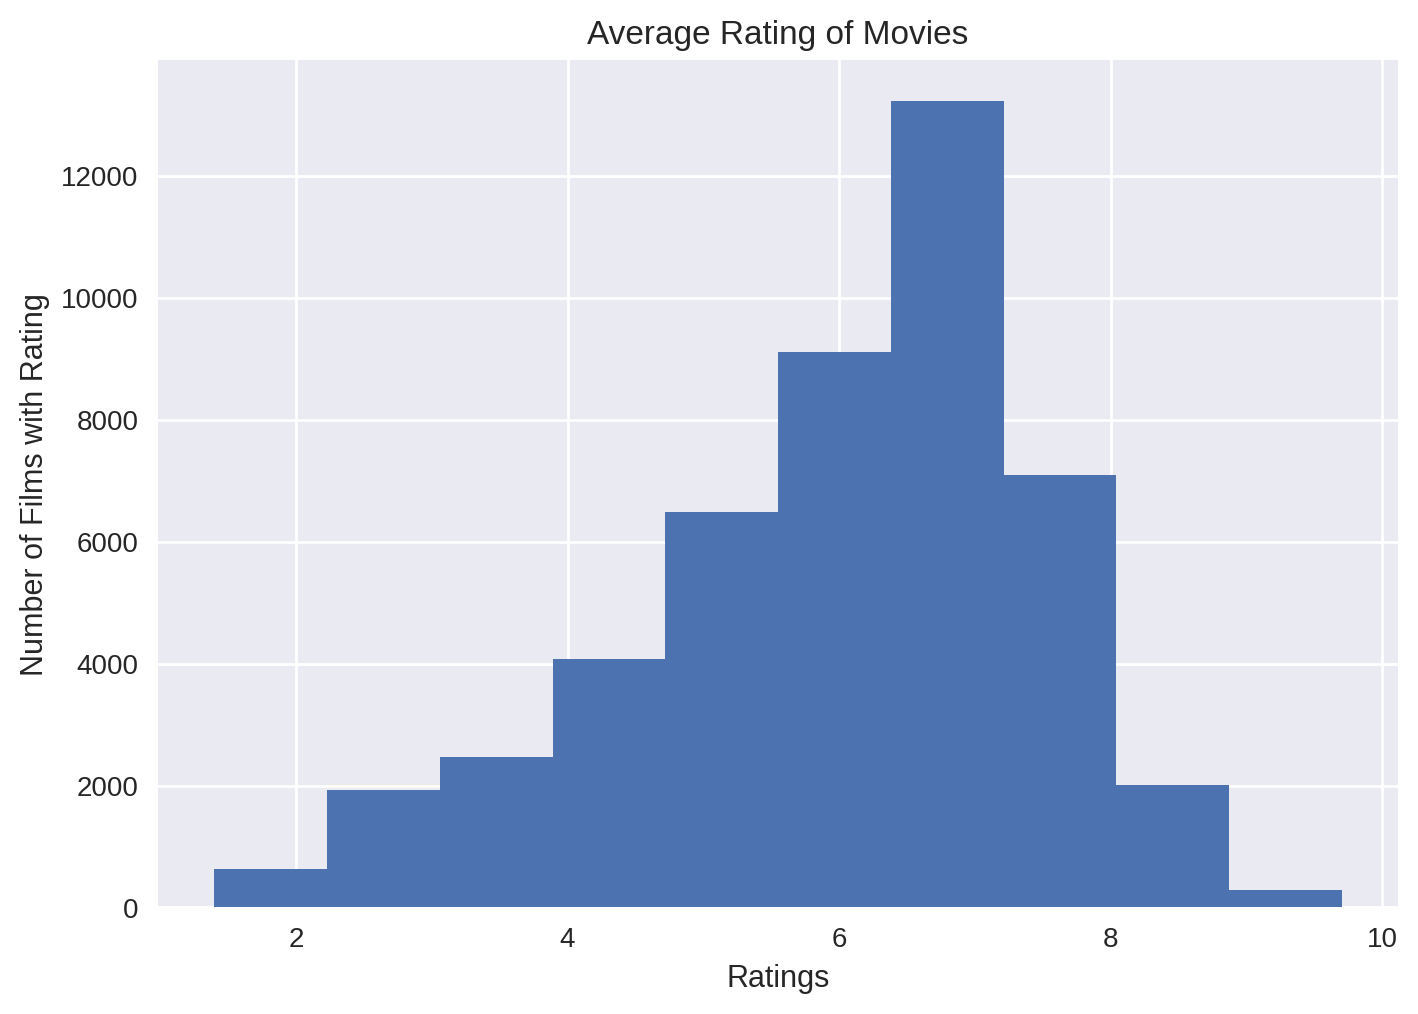

In [11]:
df_reviews['average_rating'].plot(
kind='hist')
plt.title("Average Rating of Movies")
plt.xlabel("Ratings")
plt.ylabel("Number of Films with Rating")
plt.show()

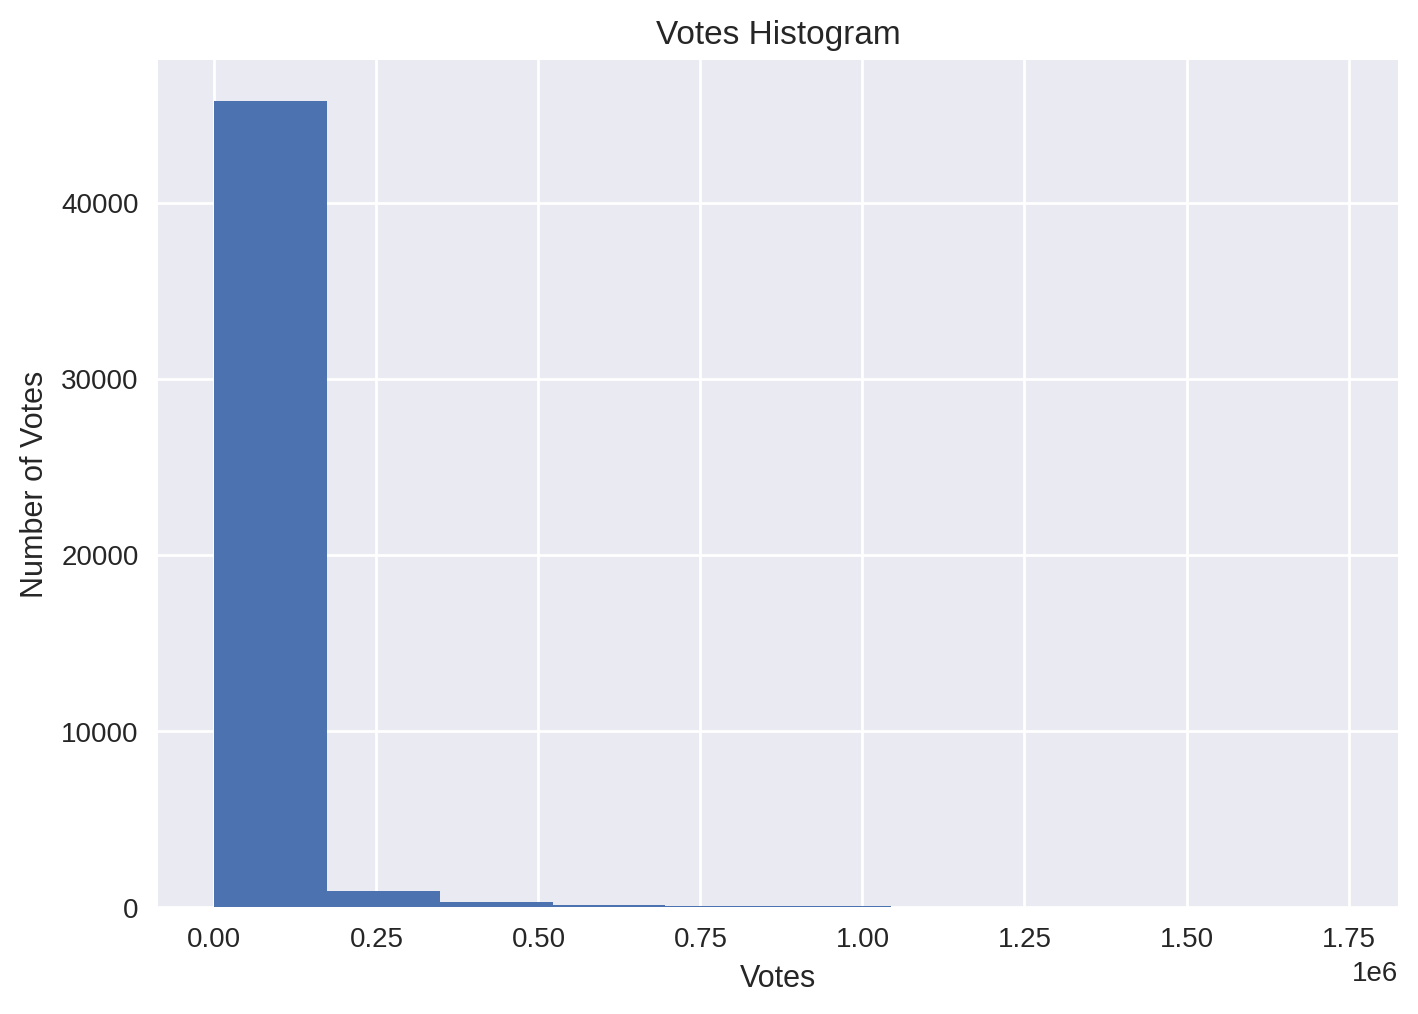

In [13]:
df_reviews['votes'].plot(
kind='hist')
plt.title("Votes Histogram")
plt.xlabel("Votes")
plt.ylabel("Number of Votes")
plt.show()

In [14]:
df_reviews['average_rating'] = df_reviews['average_rating'].fillna(df_reviews['average_rating'].mean())

In [15]:
median_votes = df_reviews['votes'].median()
median_votes

3197.0

In [16]:
df_reviews['votes'] = df_reviews['votes'].fillna(median_votes)

In [17]:
df_reviews.isna().sum()

tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     0
votes              0
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64

After checking for duplicated and missing values in our dataframe, there are no duplicated values. In the other hand, in the columns "average_rating" and "votes", there was some missing values. Since the average rating column follows a normal distribution, we filled the missing values with the mean and the votes column distribution is skewed, we filled the missing values with the median.

Let's check the number of movies and reviews over years.

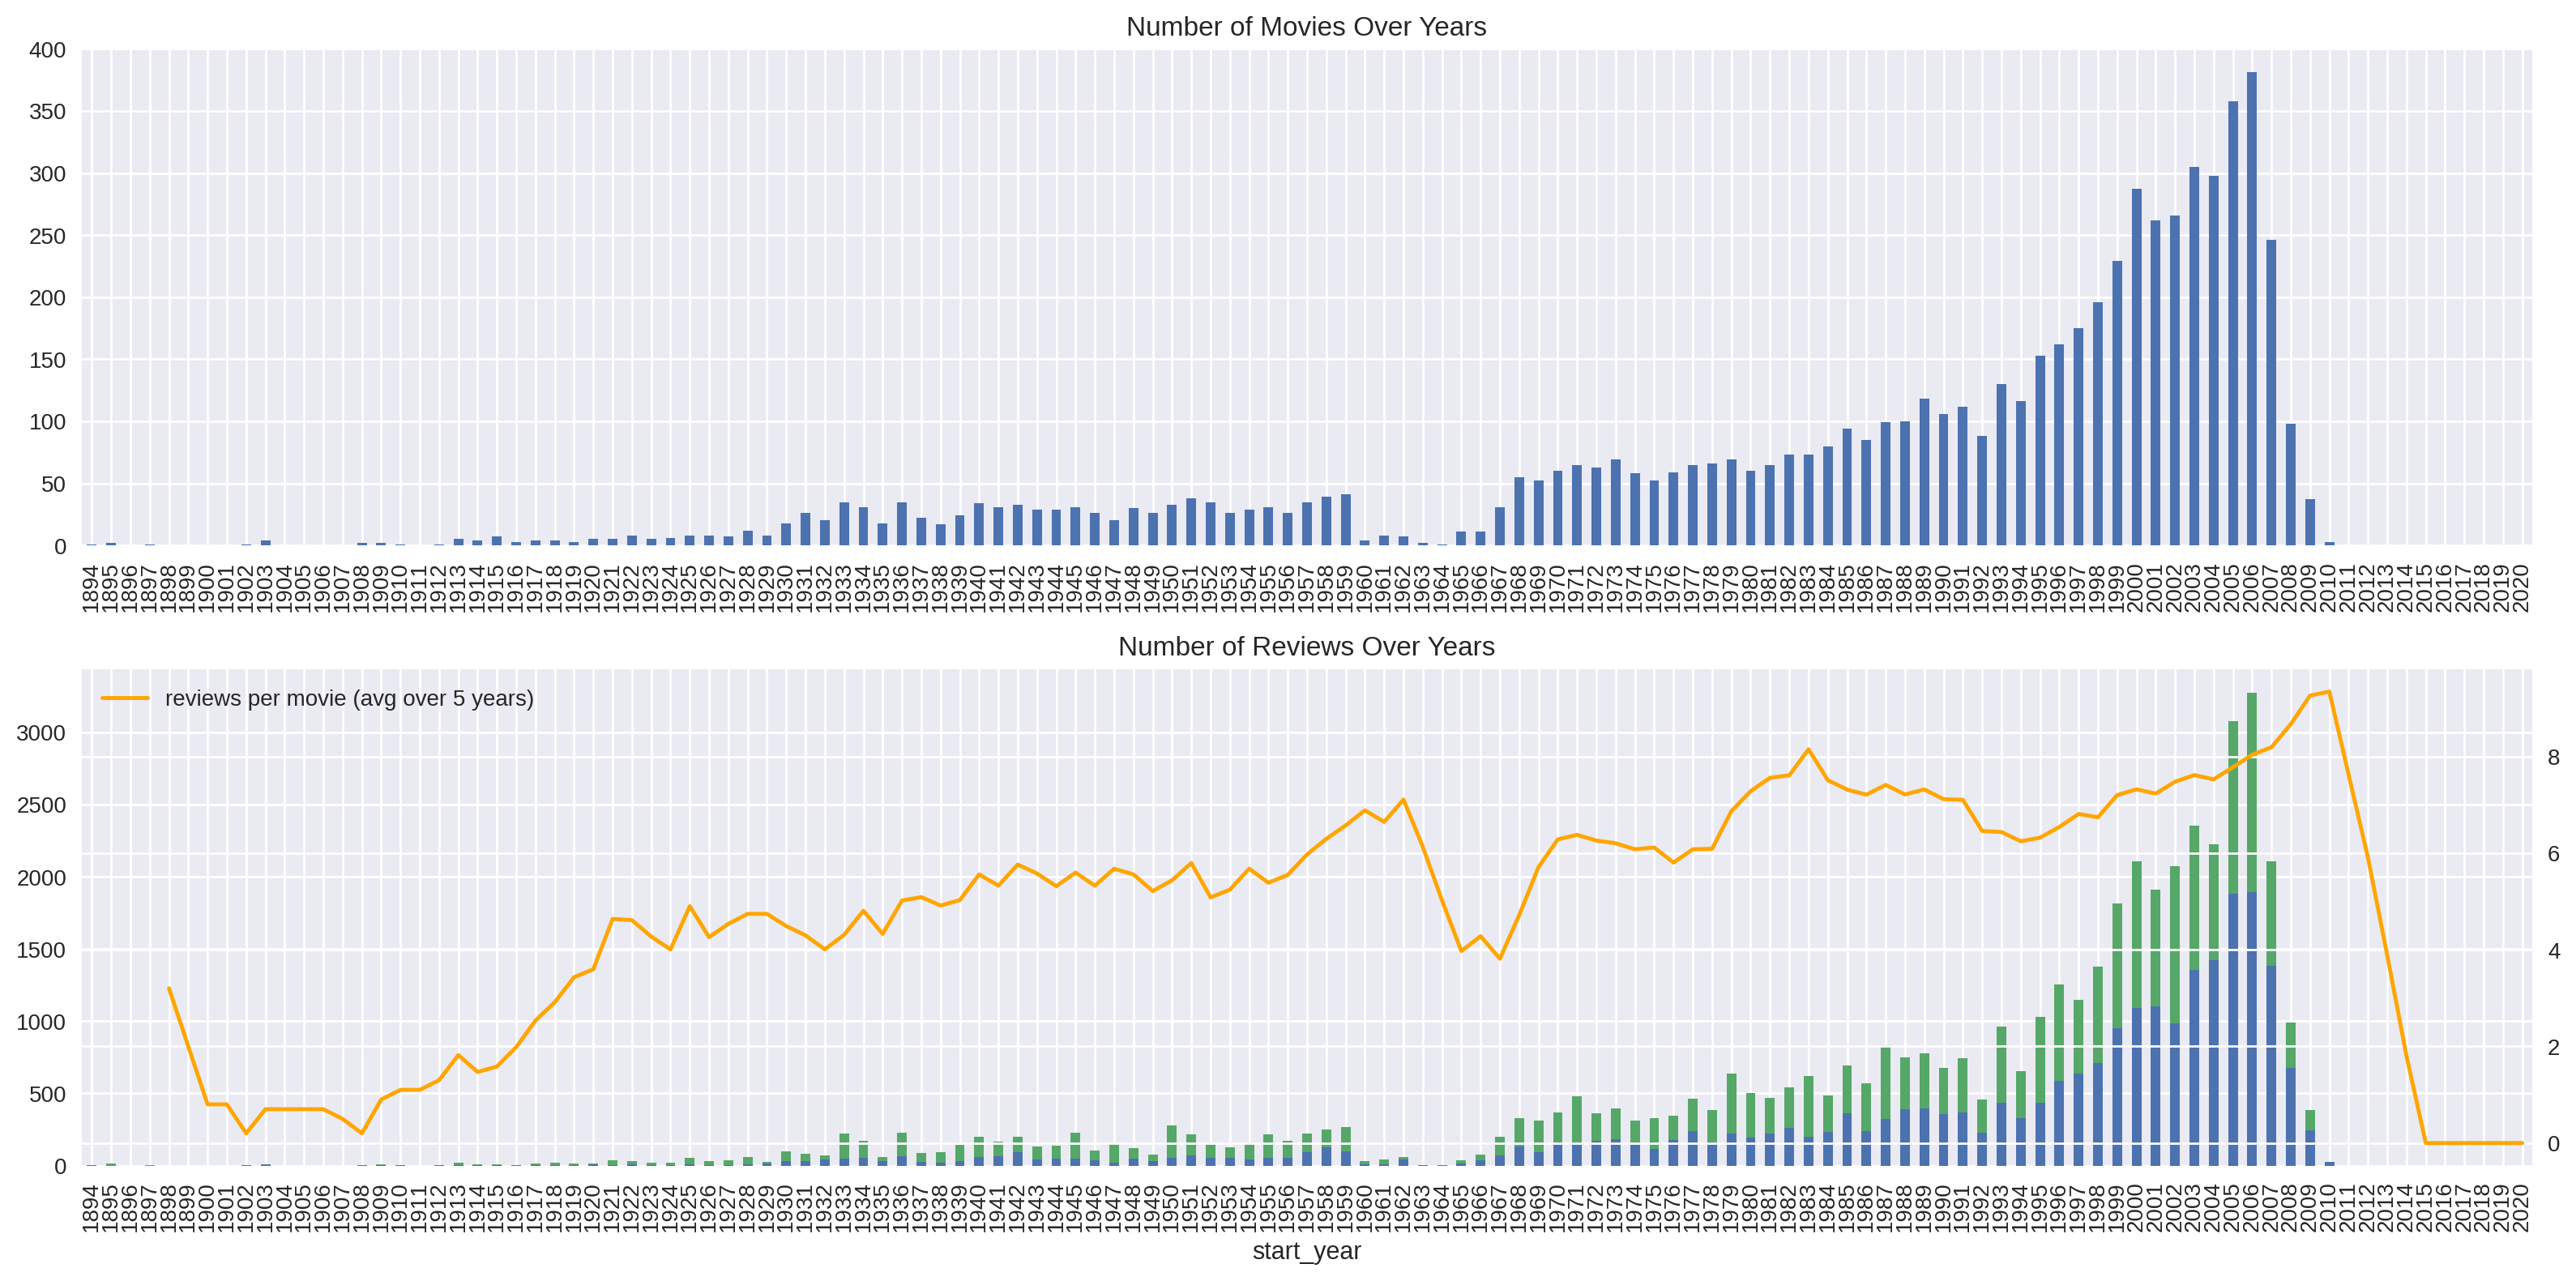

In [18]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

By looking at the charts created, one of them tells you the amount of movies made throughout the years, and the other the number of reviews over the year. You can see a direct correlation as more and more movies are made, the number of reviews increases.

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

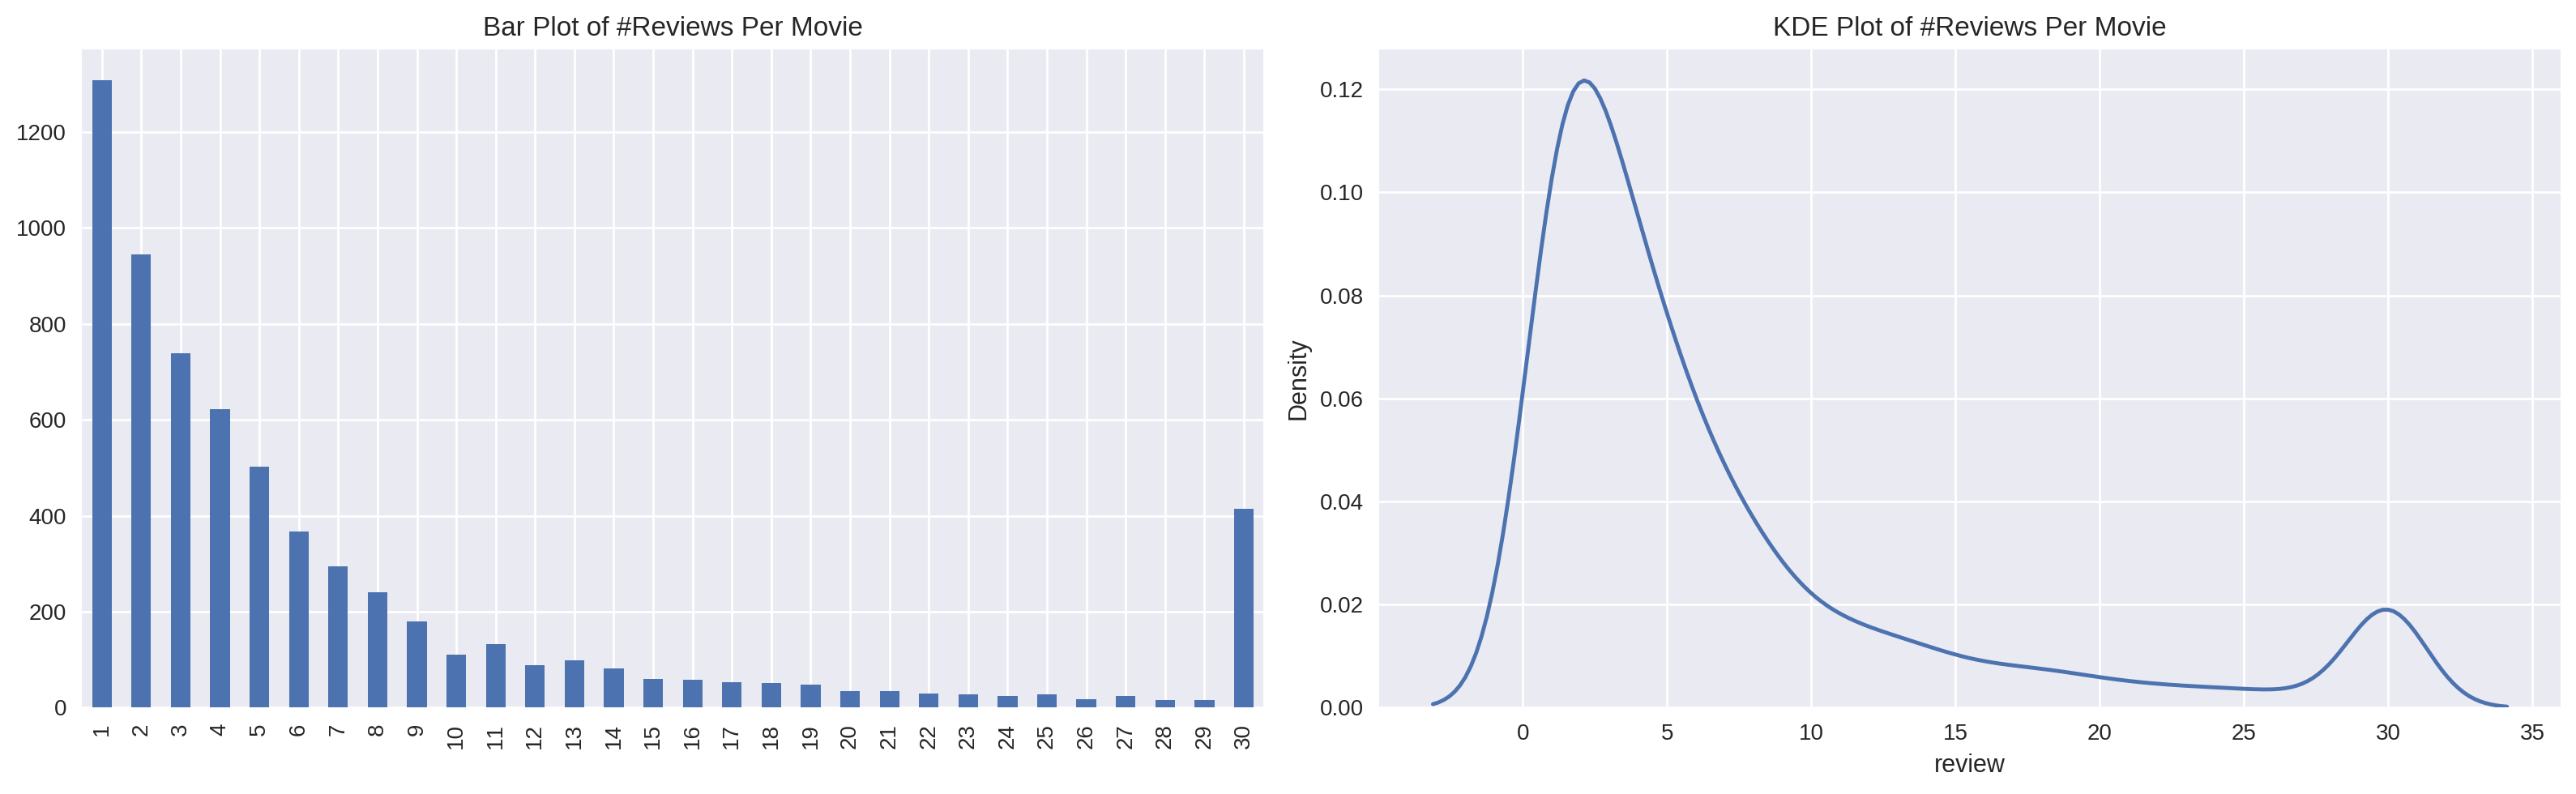

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

Overall, the peak in the distribution indicates the number of reviews per movie, therefore the peak in the distribution indicates the title with the most amount of reviews.

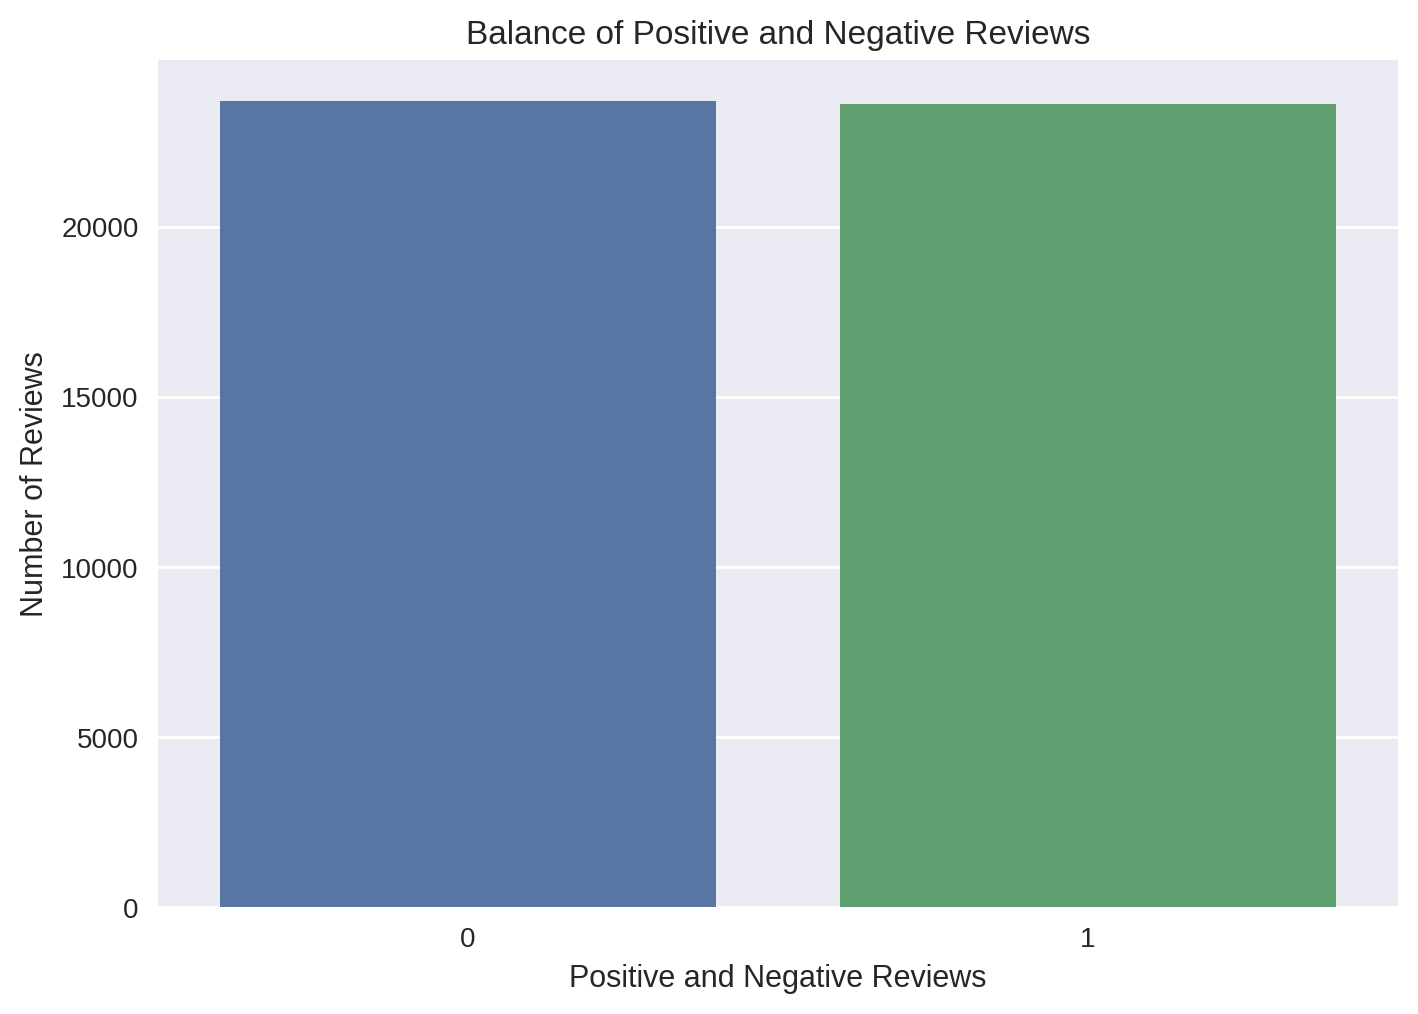

In [20]:
count_plot = sns.countplot(df_reviews['pos'])
count_plot.set_title('Balance of Positive and Negative Reviews')
count_plot.set_ylabel("Number of Reviews")
count_plot.set_xlabel("Positive and Negative Reviews")
plt.show()

Looking at the countplot created on the Positive and Negative reviews (0 being negative and 1 being positive) you can see that the two classes are balanced. Meaning, that there are roughly around the same amount of positive reviews as their is negative.

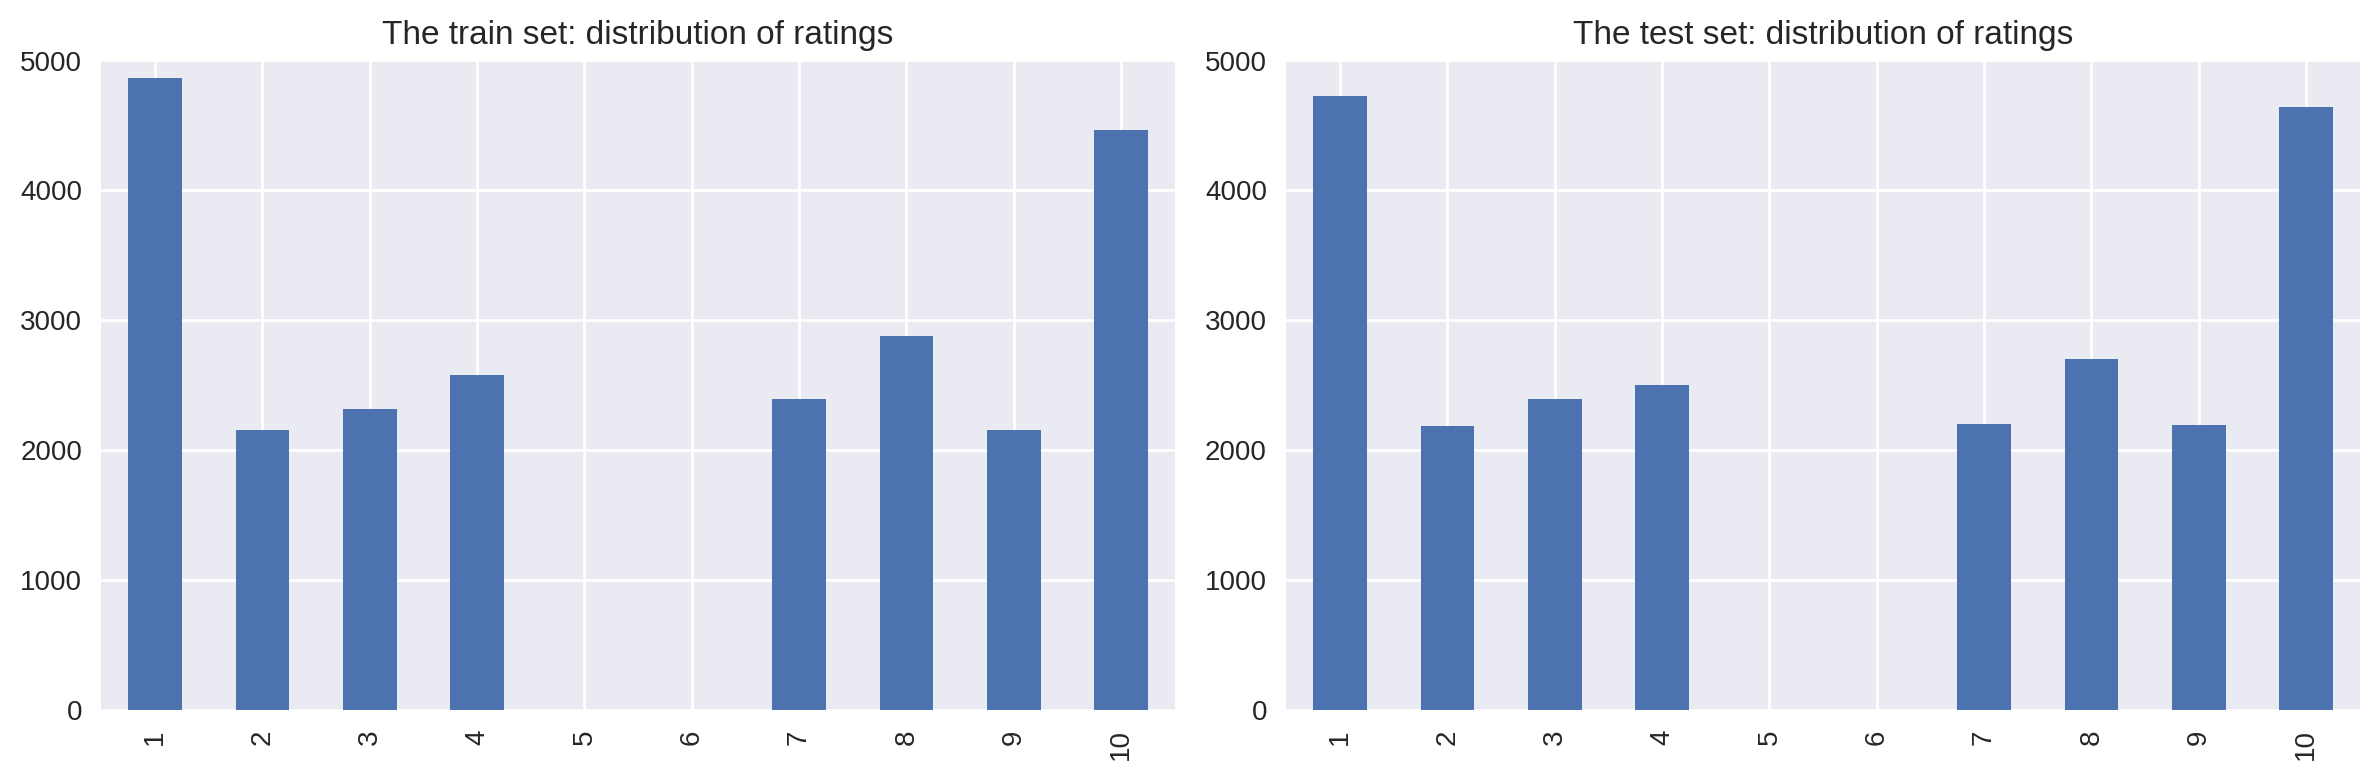

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

In these charts, they allow us to create a visualization to compare the distribution of movie ratings in the training and testing sets in the dataset. As you can see, the distribution in both are very similar. They are considered a symmetric distribution or normal distribution, because you can split them evenly right through the middle

Distribution of negative and positive reviews over the years for two parts of the dataset

/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


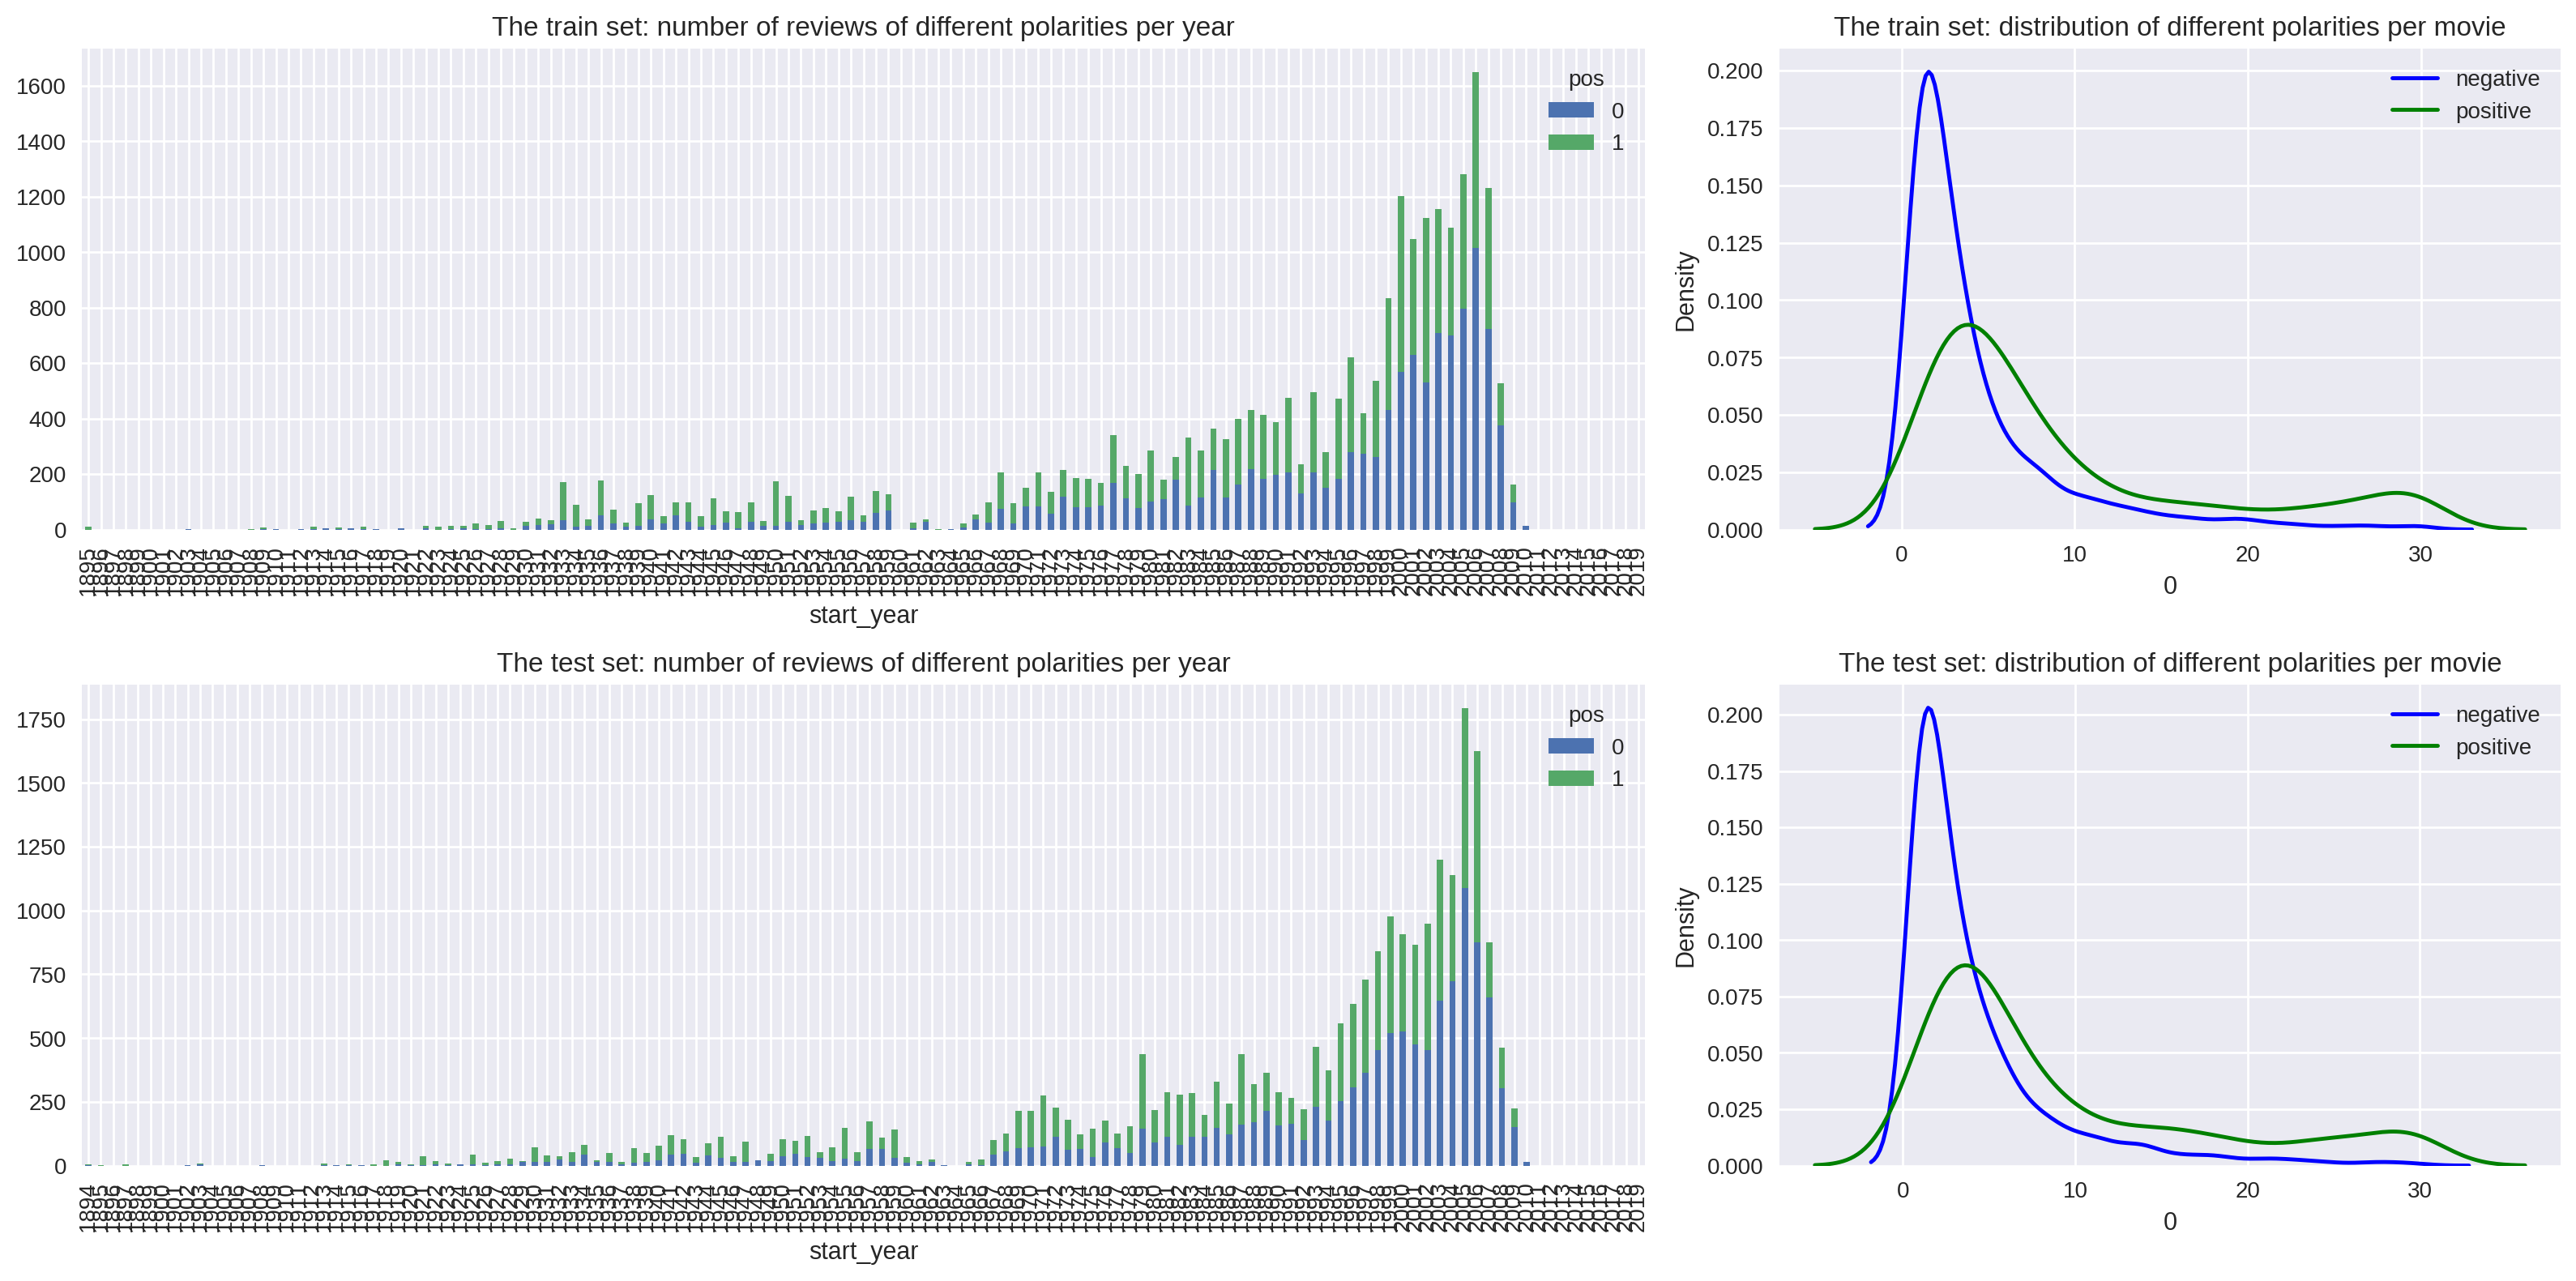

In [22]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

As you can see from the charts created, separated by the train and test sets, you can see how on both charts, the positive reviews are more than the negative reviews throughout the years.

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [24]:
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for x, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[x] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[x]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[x]['APS'] = aps
        
        if x == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{x}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{x}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{x}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[x]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[x]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [25]:
def normalize_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove digits
    text = re.sub(r'\d+', '', text)
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    return text

df_reviews['review_norm'] = df_reviews['review'].apply(normalize_text)

## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [26]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)
print(train_target.shape)
print(test_target.shape)


(23796, 18)
(23535, 18)
(23796,)
(23535,)


## Working with models

### Model 0 - Constant

In [52]:
dummy_clf = DummyClassifier(strategy="constant", constant=0) 

dummy_clf.fit(X_train_vect, train_target)

y_pred_dummy = dummy_clf.predict(X_test_vect)

print(classification_report(test_target, y_pred_dummy))
print("F1 Score:", f1_score(test_target, y_pred_dummy))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67     11803
           1       0.00      0.00      0.00     11732

    accuracy                           0.50     23535
   macro avg       0.25      0.50      0.33     23535
weighted avg       0.25      0.50      0.34     23535

F1 Score: 0.0


/opt/conda/envs/python3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/python3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/python3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


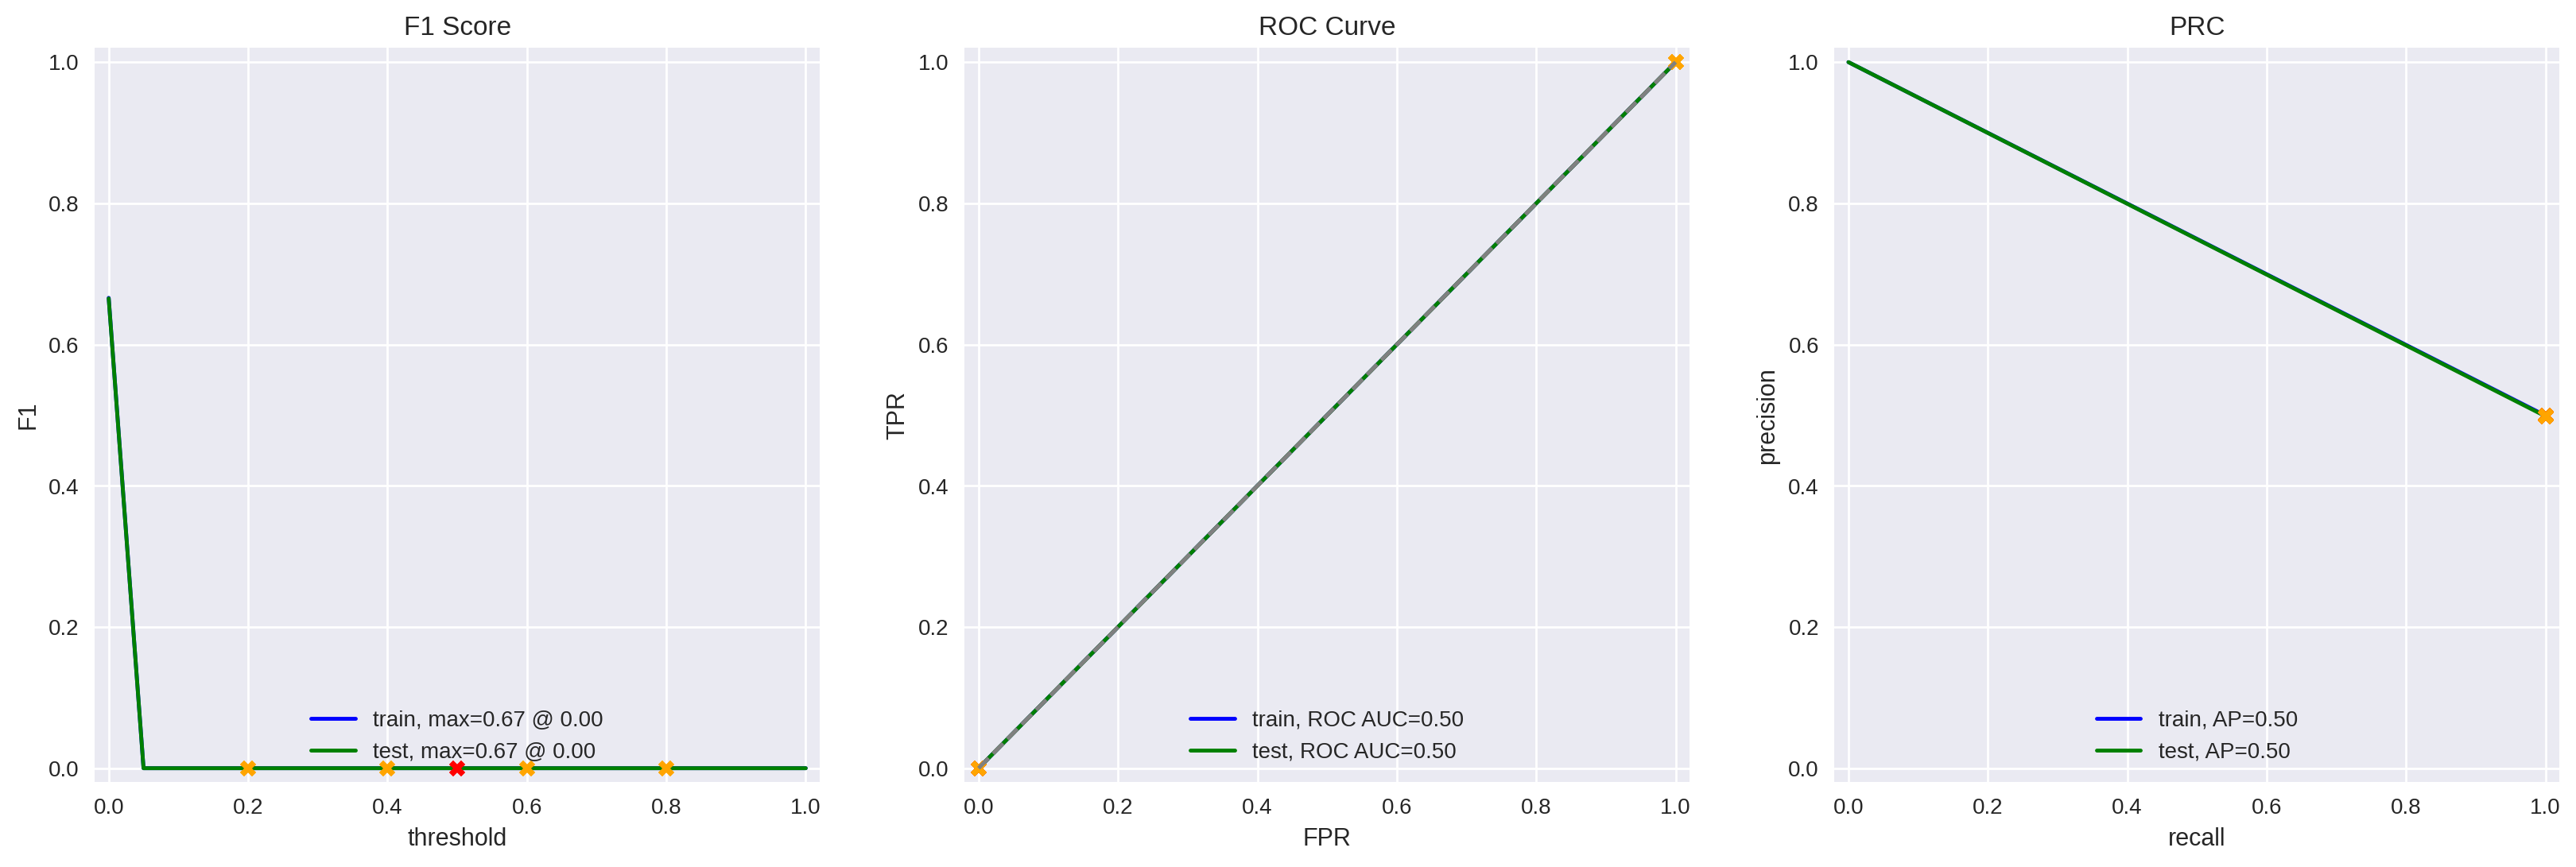

In [48]:
evaluate_model(dummy_clf, X_train_vect, train_target, X_test_vect, test_target)

Precision for class 0 (predicted negative) is 0.5, meaning half of the predicted negatives were actually negative.
Recall for class 0 is 1.0, indicating that all actual negative instances were predicted as negative (but also many positive instances were incorrectly predicted as negative). F1-score for both classes is 0, as either precision or recall is 0.
Accuracy is 0.5, again suggesting random guessing.

### Model 1 - NLTK, TF-IDF and LR

Logistic Regression:

In [29]:
vectorizer = TfidfVectorizer()
X_train_vect = vectorizer.fit_transform(df_reviews_train['review_norm'])
X_test_vect = vectorizer.transform(df_reviews_test['review_norm'])

In [31]:
model_1 = LogisticRegression()
model_1.fit(X_train_vect, train_target)
model_1_prediction = model_1.predict(X_test_vect)
f1_logistic = f1_score(test_target, model_1_prediction)
print(f"""
Logistic Regression F1 Score: {f1_logistic:.2f}
""")


Logistic Regression F1 Score: 0.88



          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


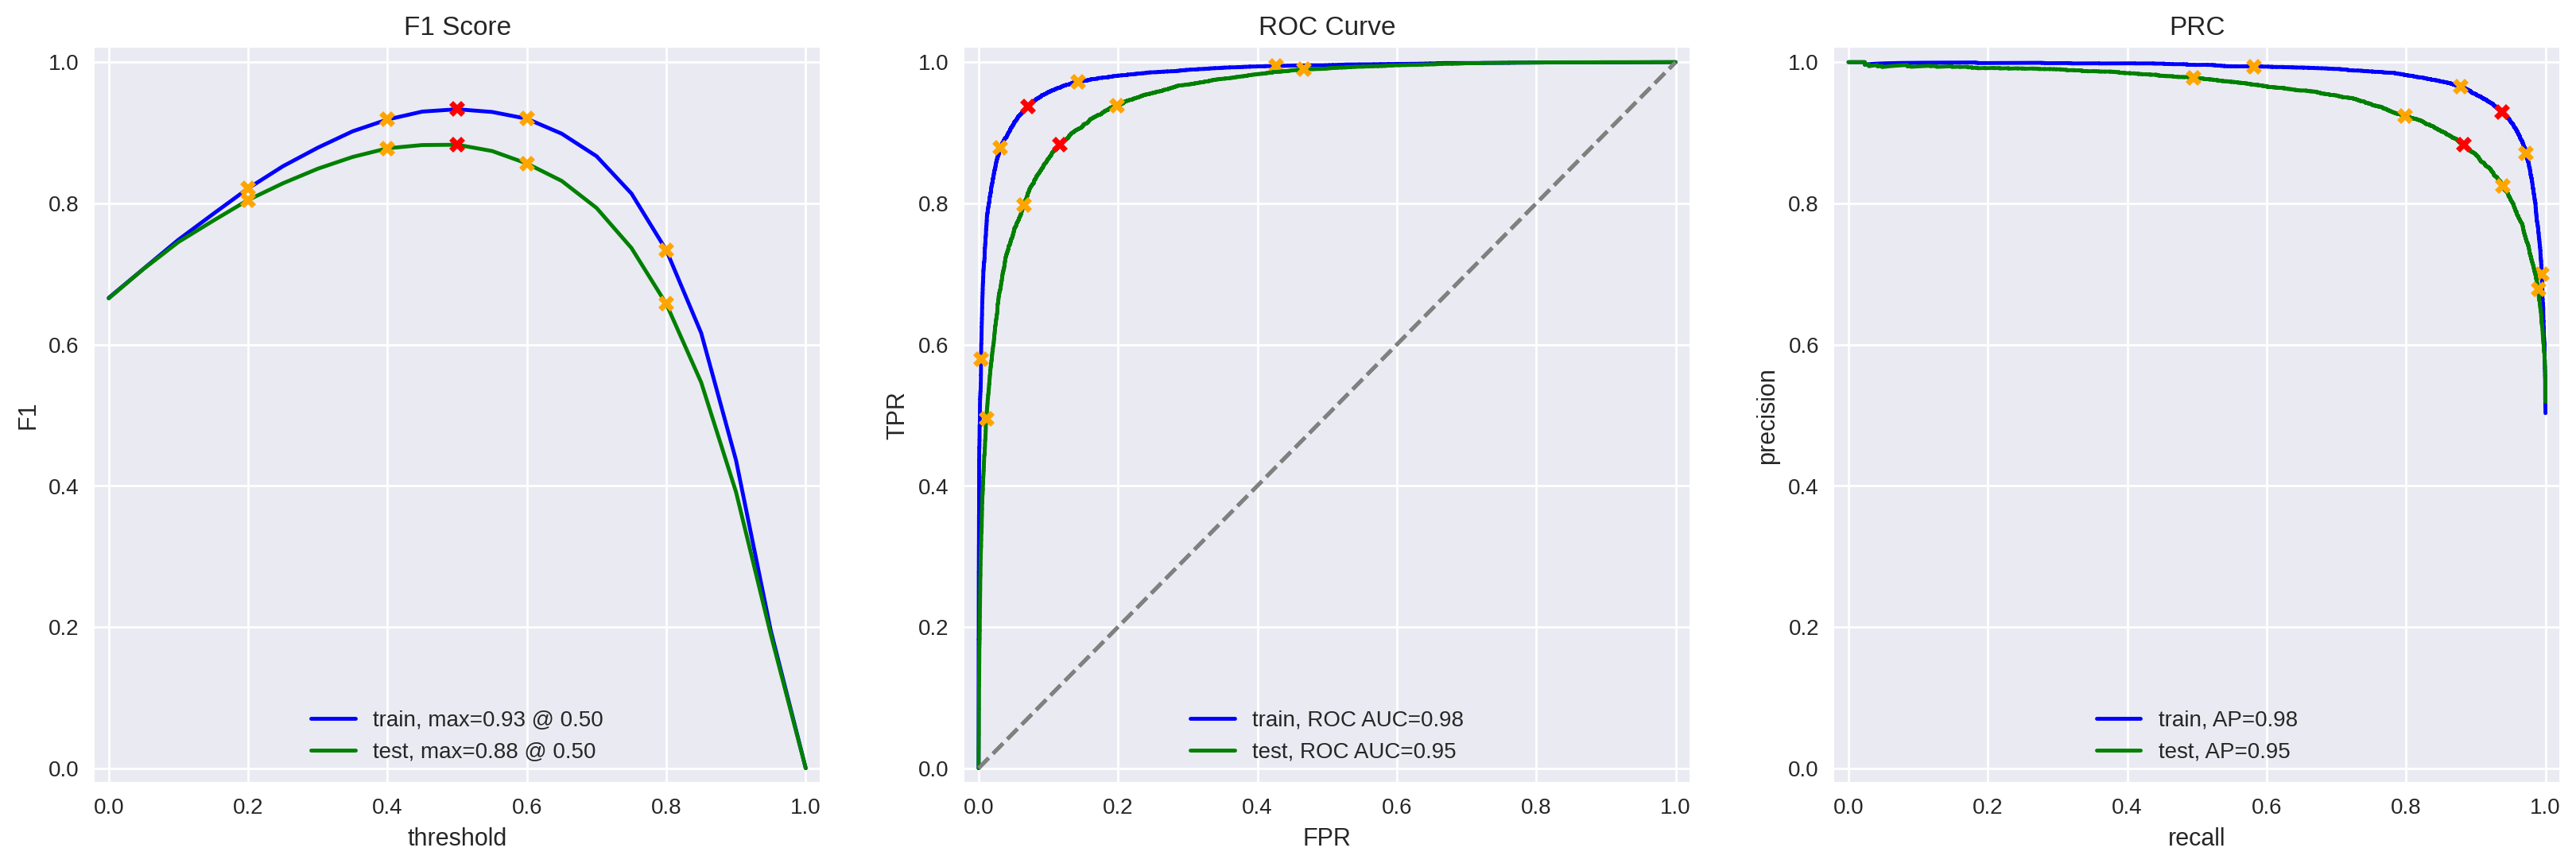

In [32]:
evaluate_model(model_1, X_train_vect, train_target, X_test_vect, test_target)

Summarizing the Logistic Regression Model, with an accuracy of 93%, the model is performing well on the data its trained on, suggesting that the model has learned the patterns, and the accuracy on the test set of 88%, indicates that the model is not overfitting and can make accurate predictions on new data. Same with the F1 Score on both the training and test datasets, with a difference of .05 and a F1 Score of .88 indicates that the model is precise with a highh percentage of true positives. The APS measures the average precision at different recall levels, considering the order of predicted positive instances. With an APS of .95, also indicates that the model correctly identifies a large portion of large positive instances. ROC AUC represents the model's ability to distinguish between positive and negative classes, with a ROC AUC of .95, it can effectively distinguish between positive and negative. 

### Model 2 - Decision Tree Classifier

In [35]:
model_decisionTree = DecisionTreeClassifier()
model_decisionTree.fit(X_train_vect, train_target)
model_decisionTree_pred = model_decisionTree.predict(X_test_vect)
f1_decisionTree = f1_score(test_target, model_decisionTree_pred)
print(f"""
Decision Tree Classifier F1 Score: {f1_decisionTree:.2f}
""")


Decision Tree Classifier F1 Score: 0.70



          train  test
Accuracy    1.0  0.70
F1          1.0  0.70
APS         1.0  0.64
ROC AUC     1.0  0.70


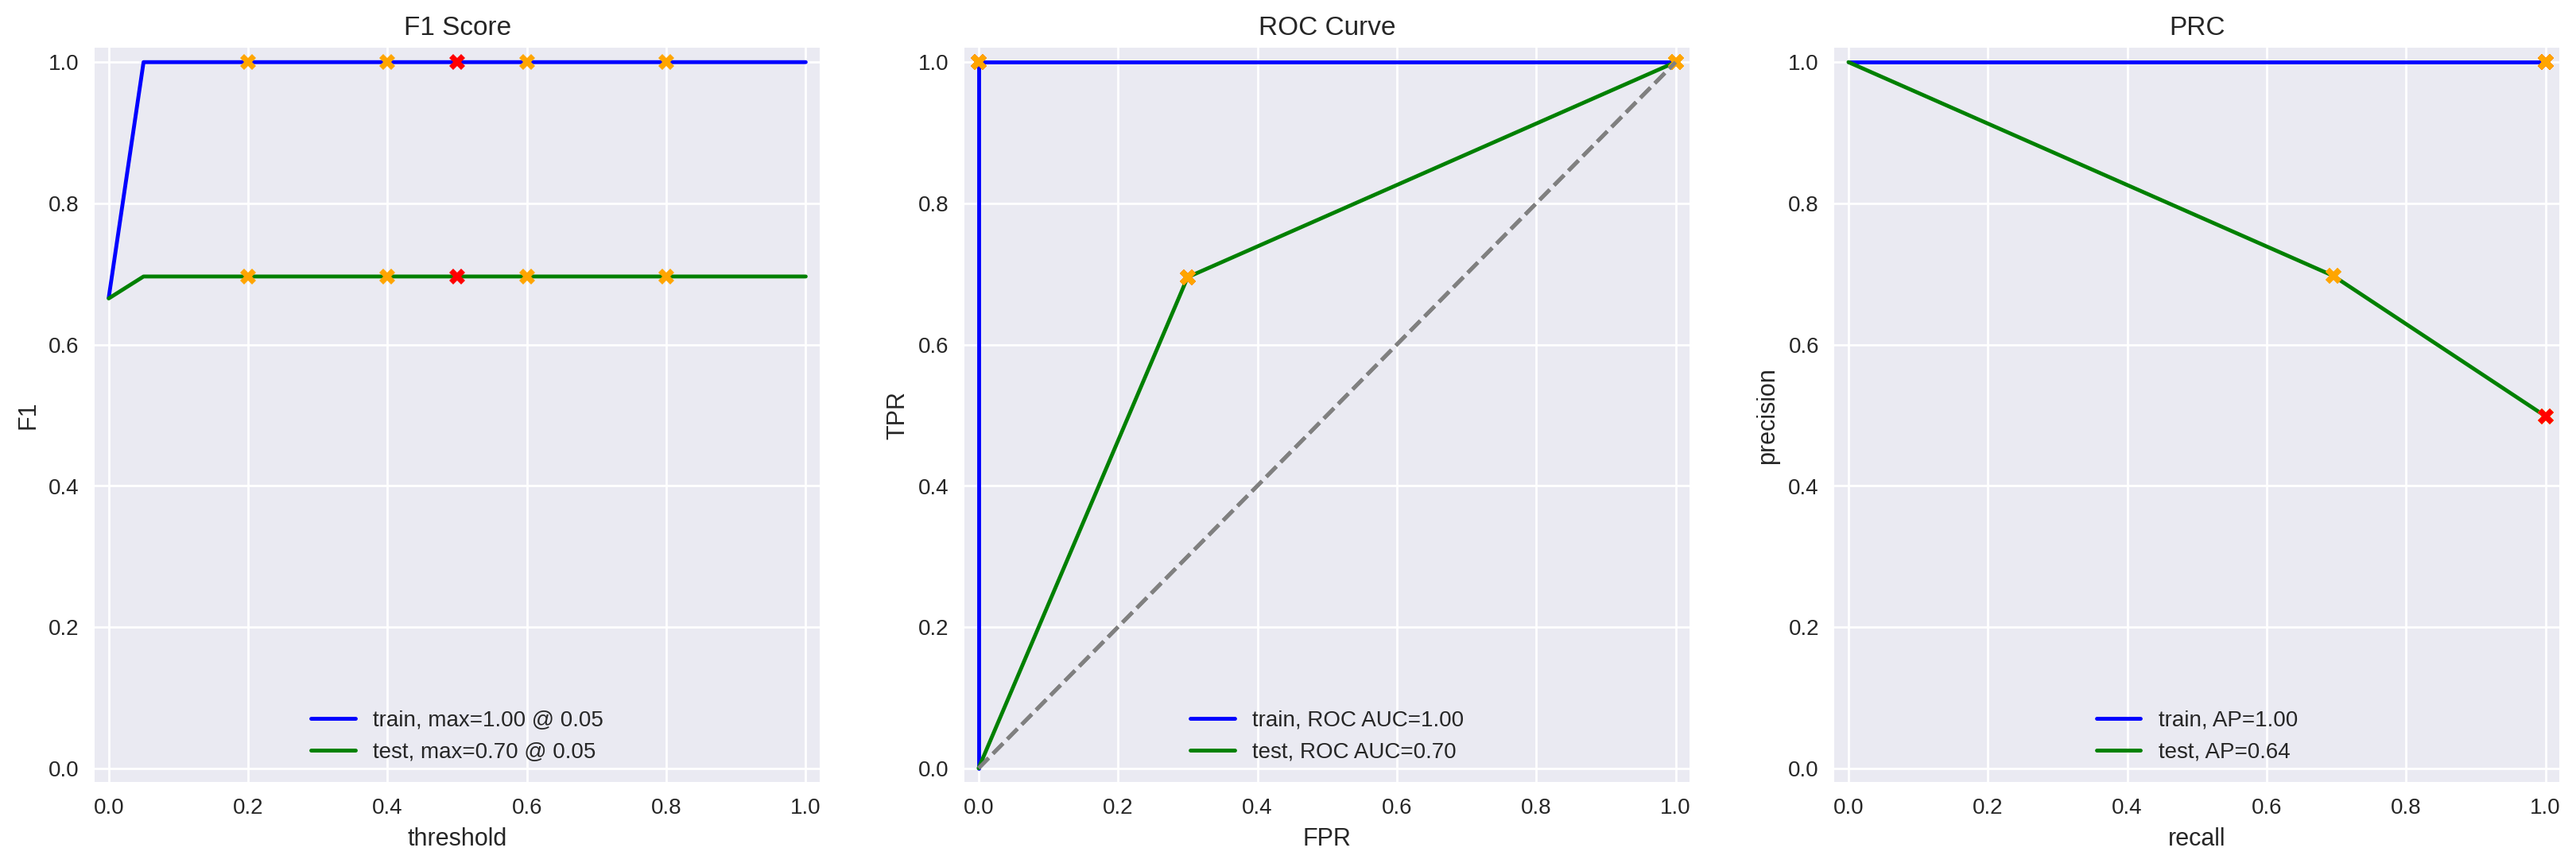

In [34]:
evaluate_model(model_decisionTree, X_train_vect, train_target, X_test_vect, test_target)

On the Decision Tree Classifier model, there is a large difference of .30, between the training and test, suggesting that model could be overfitting or not well regularized. The F1 score is achieving a relatively high F1 Score on the test data, but significantly lower than the training score, with the test f1 score of .70, and on the training set of 1.0, also a 30% difference. The ROC AUC on the test set is 70%, meaning that it can distinguish 70% of the positive and negative classes.

### Model 3 - Random Forest Classifier

In [36]:
model_random_forest = RandomForestClassifier()
model_random_forest.fit(X_train_vect, train_target)
model_random_forest_pred = model_random_forest.predict(X_test_vect)
f1_random_forest = f1_score(test_target, model_random_forest_pred)
print(f"""
Random Forest Classifier F1 Score: {f1_random_forest:.2f}
""")


Random Forest Classifier F1 Score: 0.83



          train  test
Accuracy    1.0  0.84
F1          1.0  0.83
APS         1.0  0.90
ROC AUC     1.0  0.92


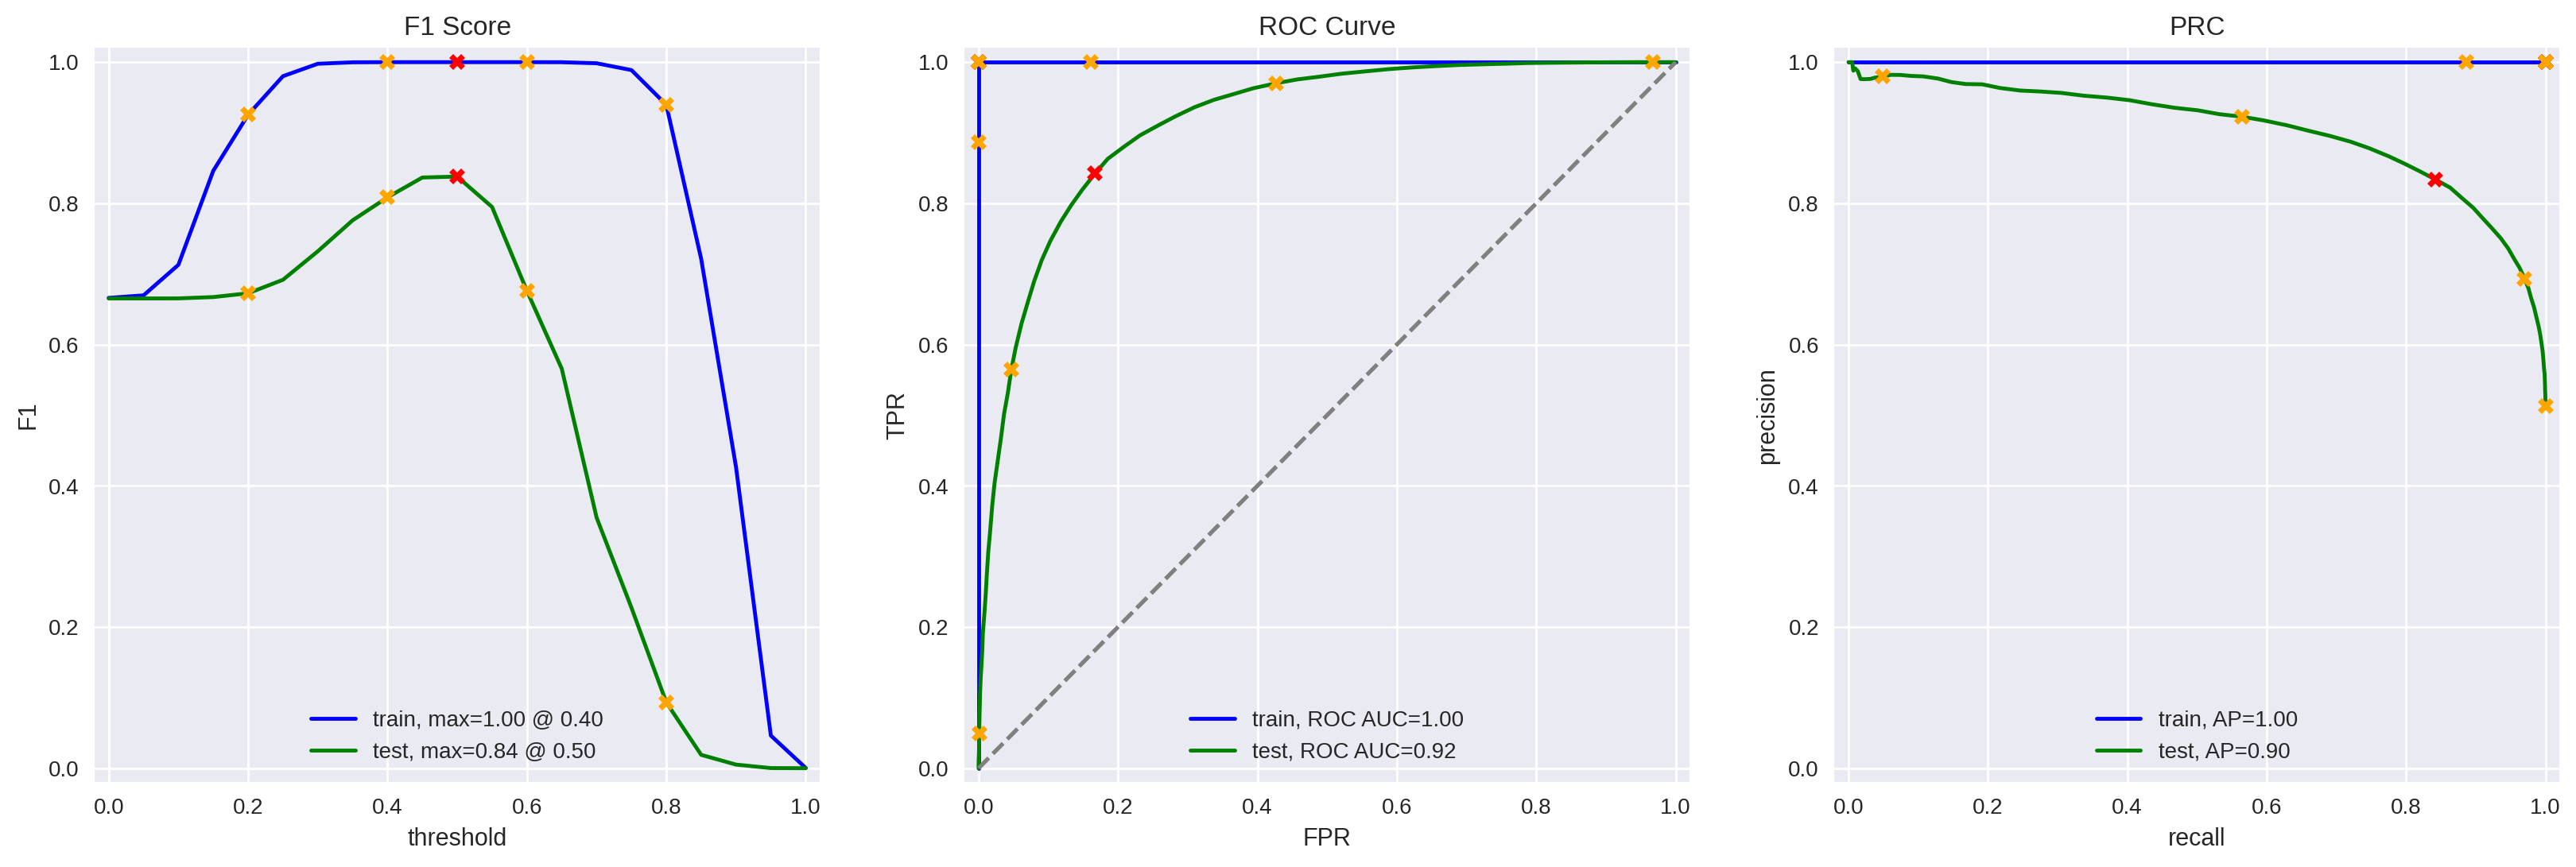

In [37]:
evaluate_model(model_random_forest, X_train_vect, train_target, X_test_vect, test_target)

In the Random Forest Classifier, looking at the ROC AUC on the test set, it has a score of 92%, being able to distinguish between positive and negative classes up to 92%. The Accuracy Score on the test set is 84%, meaning that it predicted .84 of correct predictions between training and test set. The f1 Score on the training set of 1.0 and on the test set of .83, meaning that, its overall performance is 83%, just a little bit shy of the 84% threshold to pass.

## My Reviews

In [45]:

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].apply(normalize_text)

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didnt expect the reboot to be so good writer...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i reall...


### Model 2

In [41]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_1.predict_proba(vectorizer.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.15:  i did not simply like it not my kind of movie
0.25:  well i was bored and felt asleep in the middle of the movie
0.48:  i was really fascinated with the movie
0.16:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.22:  i didnt expect the reboot to be so good writers really cared about the source material
0.64:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.04:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.73:  launching on netflix was a brave move  i really appreciate being able to binge on episode after epis


### Model 3

In [42]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_decisionTree.predict_proba(vectorizer.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

1.00:  i did not simply like it not my kind of movie
1.00:  well i was bored and felt asleep in the middle of the movie
1.00:  i was really fascinated with the movie
1.00:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
1.00:  i didnt expect the reboot to be so good writers really cared about the source material
1.00:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
1.00:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
1.00:  launching on netflix was a brave move  i really appreciate being able to binge on episode after epis


### Model 4

In [43]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_random_forest.predict_proba(vectorizer.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.62:  i did not simply like it not my kind of movie
0.79:  well i was bored and felt asleep in the middle of the movie
0.78:  i was really fascinated with the movie
0.49:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.59:  i didnt expect the reboot to be so good writers really cared about the source material
0.47:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.44:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.69:  launching on netflix was a brave move  i really appreciate being able to binge on episode after epis


## Conclusions

In [44]:
my_reviews_pred_prob = model_1.predict_proba(vectorizer.transform(texts))[:, 1]

# Create a DataFrame with review text and predicted probabilities
results_df = pd.DataFrame({'review': texts, 'predicted_probability': my_reviews_pred_prob})

# Sort by predicted probability
results_df = results_df.sort_values(by='predicted_probability', ascending=False)

# Print top 10 reviews with highest probabilities
print(results_df.head(10))

                                              review  predicted_probability
7  launching on netflix was a brave move  i reall...               0.730456
5  the movie had its upsides and downsides but i ...               0.636051
2             i was really fascinated with the movie               0.482970
1  well i was bored and felt asleep in the middle...               0.250365
4  i didnt expect the reboot to be so good writer...               0.215839
3  even the actors looked really old and disinter...               0.161744
0      i did not simply like it not my kind of movie               0.150957
6  what a rotten attempt at a comedy not a single...               0.039537


Considering out of the three models created the Logistic Regression Model was the best model out of the three with in F1 Score of .90, compared to the .71 of the Decision Tree Classifier and the .84 of the Random Forest Classifier. Also, above I created a dataframe with the reviews with the highest probabilities. 